In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import xesmf
sys.path.append("/home/149/ab8992/tasman-tides/")
import dask
from dask.distributed import Client,default_client
import ttidelib as tt
def startdask():
    try:
    # Try to get the existing Dask client
        client = default_client()
        print(client)
    except ValueError:
        # If there's no existing client, create a new one
        client = Client()
        print(client)
    return client

client = startdask()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37079 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44569' processes=4 threads=8, memory=32.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37079/status,
Dashboard: /proxy/37079/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44569,Workers: 4
Dashboard: /proxy/37079/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:39839,Total threads: 2
Dashboard: /proxy/38513/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:45765,


# Load the input and topog from an existing experiment. Flatten the topography along the beam path

In [12]:
resolution = 10
expt = f'flat-{resolution}'
inputdir = Path(f'/g/data/nm03/ab8992/ttide-inputs')

OgTopog = xr.open_dataset(str(inputdir / f'full-{resolution}' / 'topog.nc'),chunks = "auto")

# Get the hgrid and the transect of topo
hgrid = xr.open_dataset(str(inputdir / f'full-{resolution}' / 'hgrid.nc'),chunks = "auto")
BathyTransect = -1 * xr.open_dataset(f"/g/data/nm03/ab8992/outputs/full-{resolution}/bathy_transect.nc",chunks = "auto")



## Make a smoothing function that transitions between 0 and 1 towards the edges of the rectangle

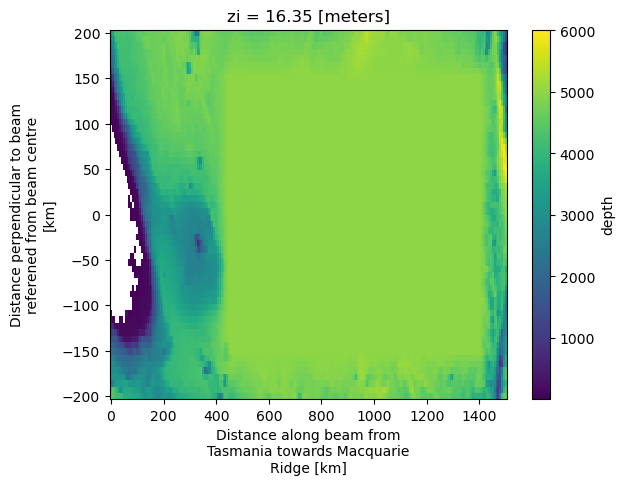

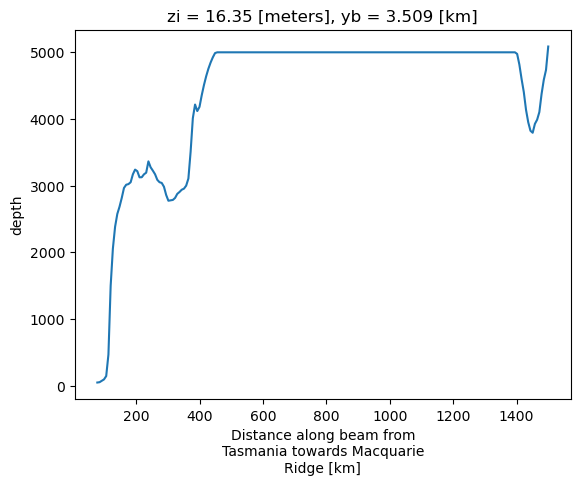

In [14]:
buffer = 50 # buffer in km
xmin,xmax,ymin,ymax = 400,1450,-200,200

smoothing = BathyTransect.depth * 0 + 1
smoothing = smoothing.where(~((smoothing.xb >= xmin) & (smoothing.xb <= xmax) & (smoothing.yb >= ymin) & (smoothing.yb <= ymax)), 0)

#Western edge
smoothing = smoothing.where(
    ~((smoothing.xb <= xmin + buffer) & (smoothing.xb >= xmin) & (smoothing.yb >= ymin) & (smoothing.yb <= ymax)),
     (buffer - (smoothing.xb - xmin))/buffer)


#Eastern edge
smoothing = smoothing.where(
    ~((smoothing.xb >= xmax - buffer) & (smoothing.xb <= xmax) & (smoothing.yb >= ymin) & (smoothing.yb <= ymax)),
     (buffer - (xmax - smoothing.xb))/buffer)

#Northern edge
# Do the corners
smoothing = smoothing.where(
    ~((smoothing.yb >= ymax - buffer) & (smoothing.yb <= ymax) & (smoothing.xb >= xmin) & (smoothing.xb <= xmax) & (smoothing != 0)),
     (buffer - (ymax - smoothing.yb))/buffer + smoothing)

# Do the rest
smoothing = smoothing.where(
    ~((smoothing.yb >= ymax - buffer) & (smoothing.yb <= ymax) & (smoothing.xb >= xmin + buffer) & (smoothing.xb <= xmax - buffer)),
     (buffer - (ymax - smoothing.yb))/buffer)



# Southern edge

# Do the corners
smoothing = smoothing.where(
    ~((smoothing.yb <= ymin + buffer) & (smoothing.yb >= ymin) & (smoothing.xb >= xmin) & (smoothing.xb <= xmax) & (smoothing != 0)),
     (buffer - (smoothing.yb - ymin))/buffer + smoothing)

# Do the rest
smoothing = smoothing.where(
    ~((smoothing.yb <= ymin + buffer) & (smoothing.yb >= ymin) & (smoothing.xb >= xmin + buffer) & (smoothing.xb <= xmax - buffer)),
     (buffer - (smoothing.yb - ymin))/buffer)

# NE 

smoothing = smoothing.where(smoothing < 1,1)
_smoothing = -1 * (smoothing - 1)


# BathyTransect.depth.plot(x = "xb",y = "yb",vmax = 0)
flatbottom = -1 * (-5000 * _smoothing + BathyTransect.depth * smoothing)


# Mask flatbotoom
flatbottom = flatbottom.where(flatbottom > 0,OgTopog.depth[0,-1,0].values)

plt.figure()
flatbottom.plot()



plt.figure()
flatbottom.sel(yb = 0,method = "nearest").plot()

flatbottom = flatbottom.sel(xb = slice(200,None))


## Now re interpolate the bathy onto the original grid and combine the two

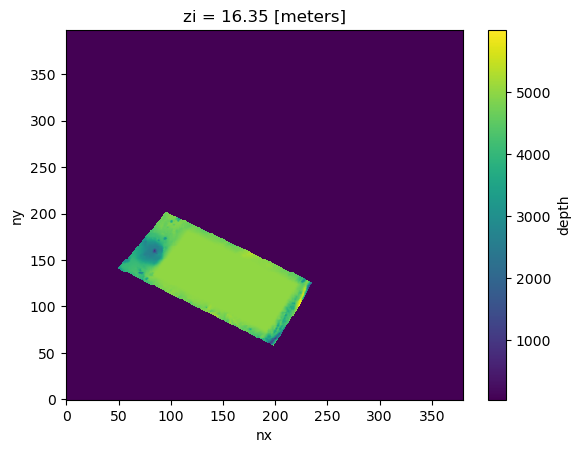

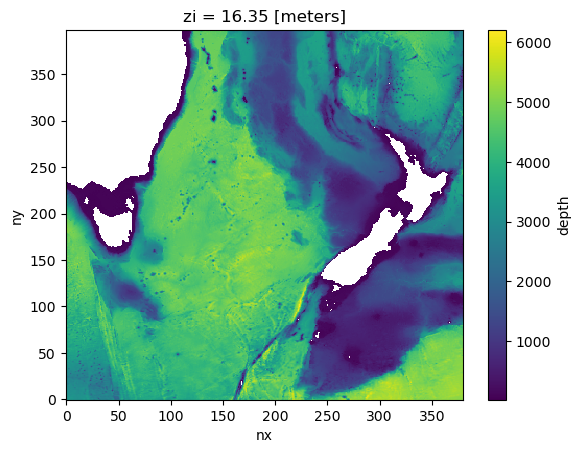

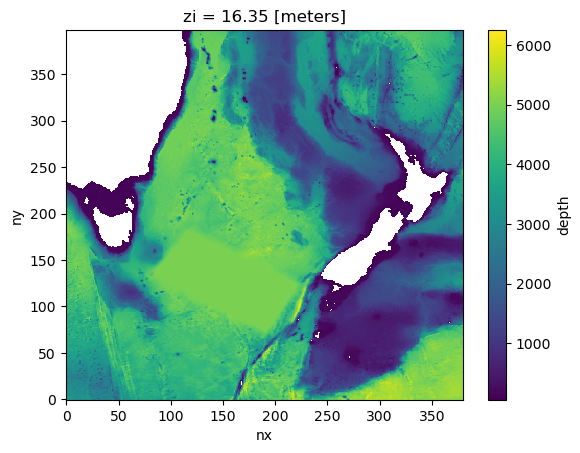

In [15]:
OgTopog = OgTopog.assign_coords({
    "lat":(["ny"],hgrid.y.isel(nxp = 0)[1::2].values),
    "lon":(["nx"],hgrid.x.isel(nyp = 0)[1::2].values)
})
basegrid = OgTopog.depth.isel(ntiles = 0) * 0 # Construct grid to interpolate the flattened topo back onto

nan = OgTopog.depth[0,-1,0]

regridder = xesmf.Regridder(
    flatbottom,basegrid,"bilinear"
)

FullFlattened = regridder(
    flatbottom,keep_attrs = True
    )

FullFlattened = FullFlattened.where(~np.isnan(FullFlattened),42) # Set placeholder value of 42
FullFlattened = FullFlattened.where(FullFlattened != 0,42) # Set placeholder value of 42 to throw these out later

FullFlattened.plot()

plt.figure()
OgTopog.depth[0,:,:].plot()

OgTopogCutout = OgTopog.depth[0,:,:].where((FullFlattened == 42) & (OgTopog.depth[0,:,:] != nan),0)


plt.figure()
(OgTopogCutout + FullFlattened).plot()


# Save to topog_flattened.nc in same folder

In [16]:
NewTopog = OgTopog * 0
NewTopog.depth[0,:,:] = (OgTopogCutout + FullFlattened)
NewTopog.to_netcdf(str(inputdir / f'full-{resolution}' / 'topog_flattened_withseamount.nc'))


# Deal with the tracers. Need to extend them downwards ensuring that they stay monatincally increasing?

<Figure size 640x480 with 0 Axes>

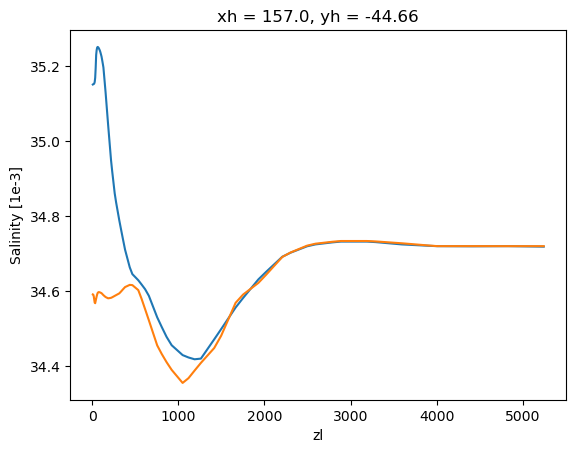

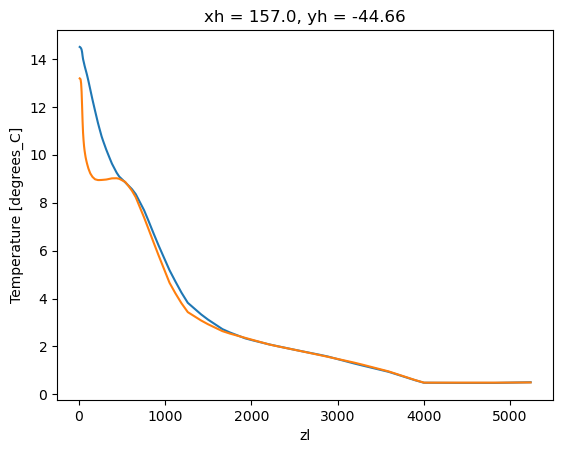

<Figure size 640x480 with 0 Axes>

In [138]:
OgTracers = xr.open_dataset(str(inputdir / f'full-{resolution}' / 'forcing/init_tracers.nc'),chunks = "auto")
newtracers = xr.open_dataset(str(inputdir / f'full-20-10year' / 'forcing/init_tracers.nc'),chunks = "auto")
newtracers.salt.isel(xh = 300,yh = 300).plot()
OgTracers.salt.isel(xh = 300,yh =300).plot()

plt.figure()
OgTracers.ffill("zl")
OgTracers.ffill("zl")

newtracers.temp.isel(xh = 300,yh =300).plot()
OgTracers.temp.isel(xh = 300,yh =300).plot()


plt.figure()
# OgTracers.to_netcdf(str(inputdir / f'full-{resolution}' / 'forcing/init_tracers_zinterp.nc'))

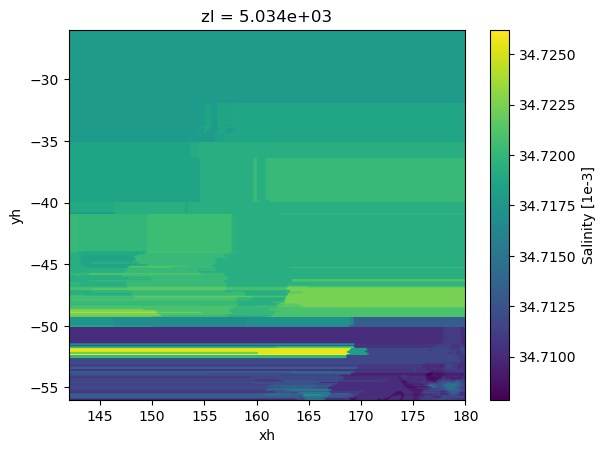

In [143]:
OgTracers.salt.sel(zl = 5000,method = "nearest").plot()